# 基于cigar10数据集的图形分类实验

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#对读取数据做个处理，打个包
#Normalize是数据归一化

trainset = torchvision.datasets.CIFAR10(root='~/Desktop/ai_defence/ckx_cifar10', train=True,
                                        download=True, transform=transform)
#封装了一个内置数据集调用的函数，初始化数据时会自动把数据拉下来拉到当前路径下
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,#表示PILImage的大小
                                          shuffle=True, num_workers=2) 
#加载测试集
testset = torchvision.datasets.CIFAR10(root='~/Desktop/ai_defence/ckx_cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
#指定类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    

Files already downloaded and verified
Files already downloaded and verified


horse  bird  ship horse


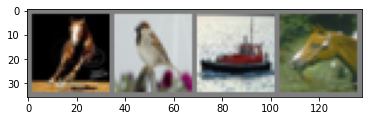

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# 展示图像的函数


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))#transpose()作用是调换数组行列值的索引值


# 获取随机数据
dataiter = iter(trainloader)#把trainloader变成一个可迭代的对象
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [43]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)#定义第一个卷积层
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)#定义第二个卷积层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)#定义第一个全连接
        self.fc2 = nn.Linear(120, 84)#定义第二个全连接
        self.fc3 = nn.Linear(84, 10)#定义第三个全连接
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))#第一个卷积层激活并池化
        x = self.pool(F.relu(self.conv2(x)))#第二个卷积层激活并池化
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [44]:
import torch.optim as optim#做优化器

criterion = nn.CrossEntropyLoss()#分类问题用交叉熵损失
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)#定义优化器（随机梯度下降）
optimizer = optim.Adam(net.parameters(), lr=0.001)#定义优化器（随机梯度下降）

In [21]:
def acc(net):
    correct = 0
    total = 0
    with torch.no_grad():#不需要梯度
        for data in testloader:
            images, labels = data
            outputs = net(images)#构造实例
            _, predicted = torch.max(outputs.data, 1)#做预估，用max取出最大的类别
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
acc(net)

Accuracy of the network on the 10000 test images: 55 %


In [45]:
for epoch in range(2):  #完整地看完一遍数据，就用一个epoch：多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000.))
            running_loss = 0.0
            acc(net)
print('Finished Training')

[1,  2000] loss: 1.882
Accuracy of the network on the 10000 test images: 37 %
[1,  4000] loss: 1.595
Accuracy of the network on the 10000 test images: 43 %
[1,  6000] loss: 1.517
Accuracy of the network on the 10000 test images: 46 %
[1,  8000] loss: 1.452
Accuracy of the network on the 10000 test images: 48 %
[1, 10000] loss: 1.409
Accuracy of the network on the 10000 test images: 50 %
[1, 12000] loss: 1.385
Accuracy of the network on the 10000 test images: 51 %
[2,  2000] loss: 1.326
Accuracy of the network on the 10000 test images: 53 %
[2,  4000] loss: 1.314
Accuracy of the network on the 10000 test images: 53 %
[2,  6000] loss: 1.299
Accuracy of the network on the 10000 test images: 53 %
[2,  8000] loss: 1.285
Accuracy of the network on the 10000 test images: 53 %
[2, 10000] loss: 1.248
Accuracy of the network on the 10000 test images: 56 %
[2, 12000] loss: 1.258
Accuracy of the network on the 10000 test images: 56 %
Finished Training


### 训练记录

|dropout|epoch|optim|result|
|  ----  | ----  |----|----|
|0.1|2|sgd|53%|
|0.1|4|sgd|57%|
|0.5|2|sgd|48%|
|0.5|2|adam|47%|
|0.1|2|adam|52%|
|0.1|4|adam|54%|
|0.|2|adam|56%|





### 图片显示

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


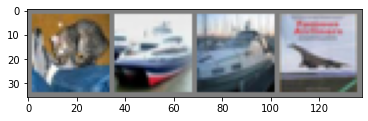

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
